Processing data for EPL (2020) with date range 2020-02-01 to 2021-07-01...
Loading data from epl_team_data_2020_2021.json...


,team,h_a,xG,xGA,scored,wins,draws,loses,result,date
0,Aston Villa,h,0.805270,0.849709,1,1,0,0,w,2020-09-21 17:00:00
1,Aston Villa,a,2.032220,0.534675,3,1,0,0,w,2020-09-28 17:00:00
2,Aston Villa,h,3.076260,1.657050,7,1,0,0,w,2020-10-04 18:15:00
3,Aston Villa,a,0.873776,0.671595,1,1,0,0,w,2020-10-18 18:15:00
4,Aston Villa,h,1.501250,2.376950,0,0,0,1,l,2020-10-23 19:00:00
...,...,...,...,...,...,...,...,...,...,...
755,Leeds,a,0.510874,2.525420,0,0,0,1,l,2021-05-01 14:00:00
756,Leeds,h,2.552160,1.033840,3,1,0,0,w,2021-05-08 11:30:00
757,Leeds,a,1.856540,1.413380,4,1,0,0,w,2021-05-15 11:30:00
758,Leeds,a,1.581320,1.308400,2,1,0,0,w,2021-05-18 17:00:00


Mann-Whitney U test for EPL (2020):
p-value = 0.11726
Result: No significant difference in xG distributions between home and away games.


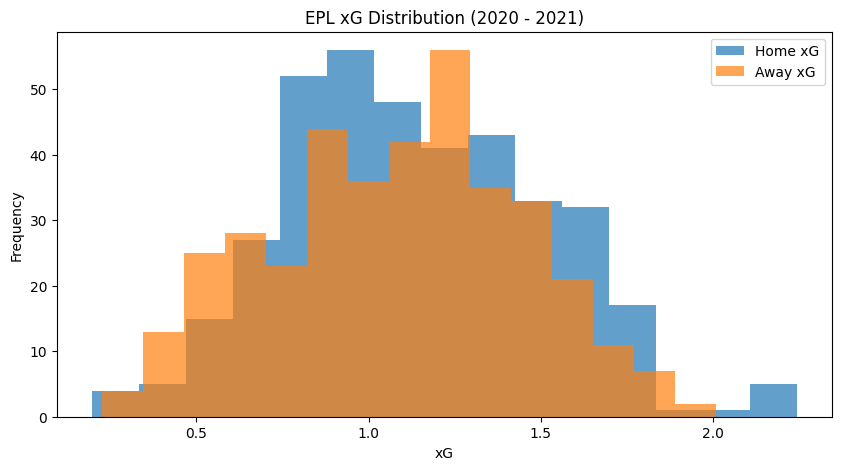

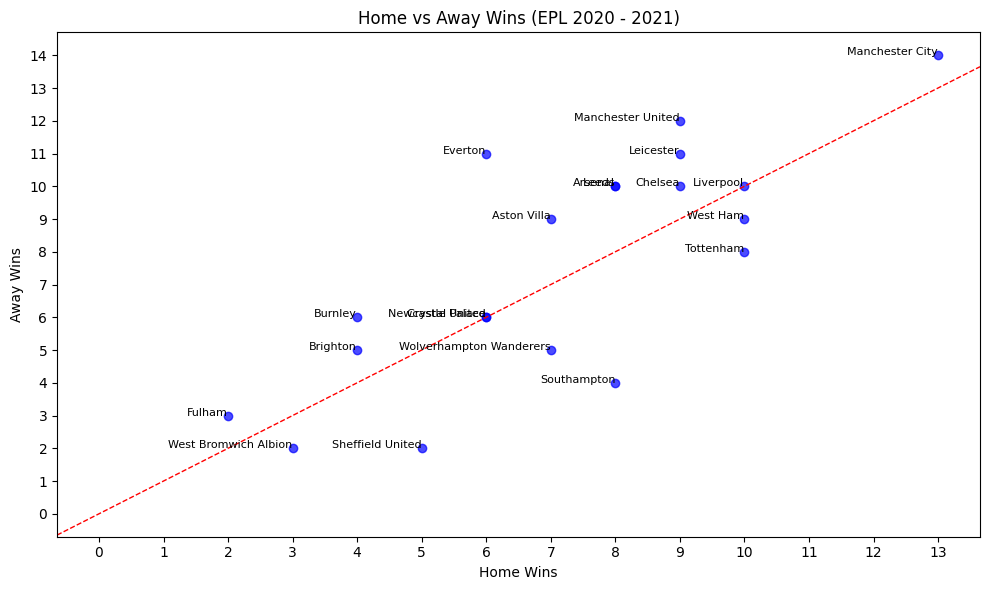

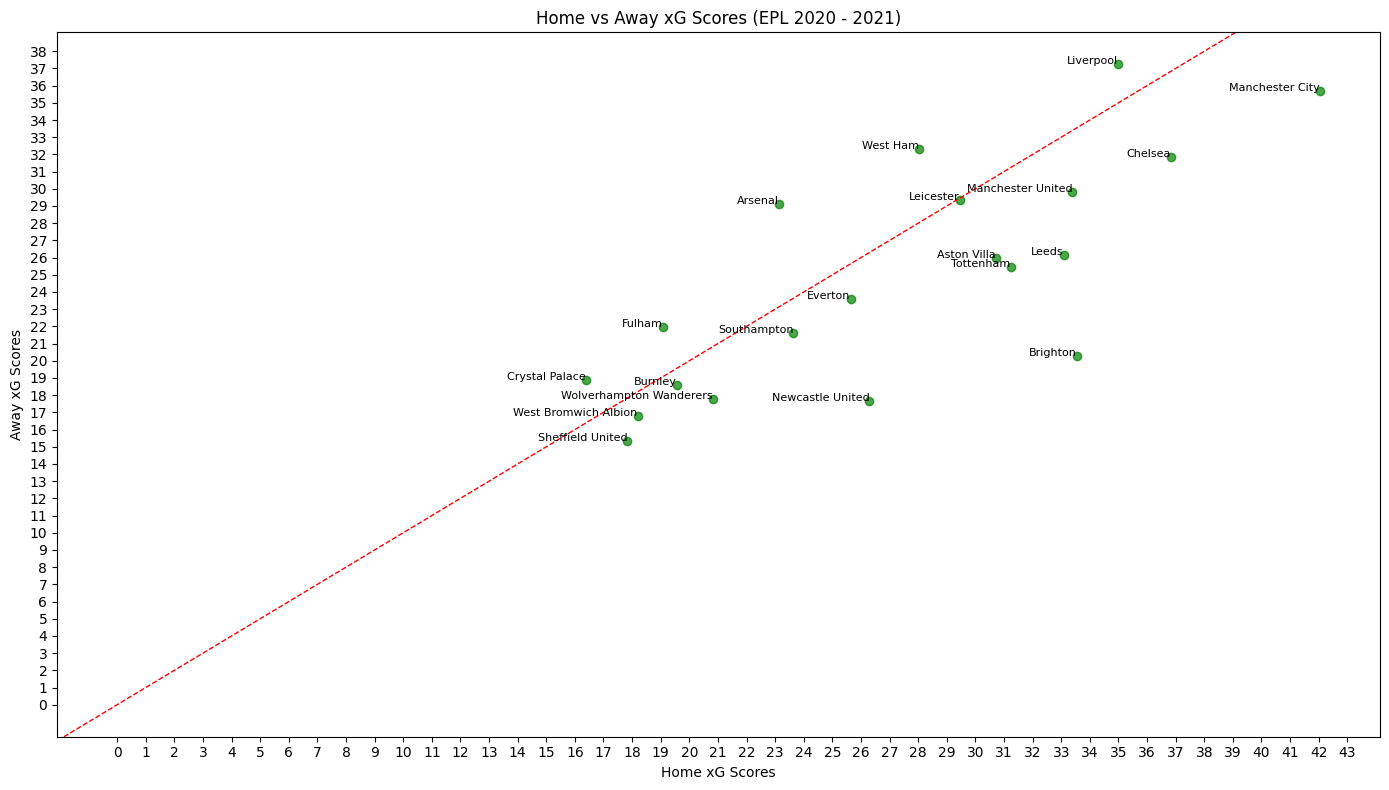

Processing data for EPL (2019) with date range 2020-02-01 to 2021-07-01...
Loading data from epl_teams_data_2019_2020.json...


,team,h_a,xG,xGA,scored,wins,draws,loses,result,date
0,Aston Villa,a,0.639599,2.572620,1,0,0,1,l,2019-08-10 17:30:00
1,Aston Villa,h,1.650690,1.627770,1,0,0,1,l,2019-08-17 15:00:00
2,Aston Villa,h,0.855926,1.256680,2,1,0,0,w,2019-08-23 20:00:00
3,Aston Villa,a,0.303540,1.413940,0,0,0,1,l,2019-08-31 15:00:00
4,Aston Villa,h,1.405020,0.535279,0,0,1,0,d,2019-09-16 19:00:00
...,...,...,...,...,...,...,...,...,...,...
755,Sheffield United,h,0.470483,0.326909,1,1,0,0,w,2020-07-08 17:00:00
756,Sheffield United,h,2.006320,1.175090,3,1,0,0,w,2020-07-11 16:30:00
757,Sheffield United,a,0.660214,3.057520,0,0,0,1,l,2020-07-16 17:00:00
758,Sheffield United,h,0.468461,0.624814,0,0,0,1,l,2020-07-20 17:00:00


Mann-Whitney U test for EPL (2019):
p-value = 0.01037
Result: Significant difference in xG distributions between home and away games.


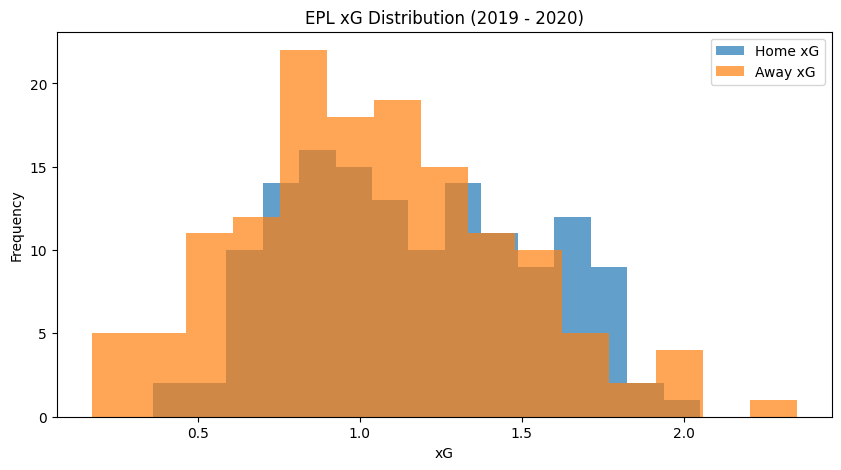

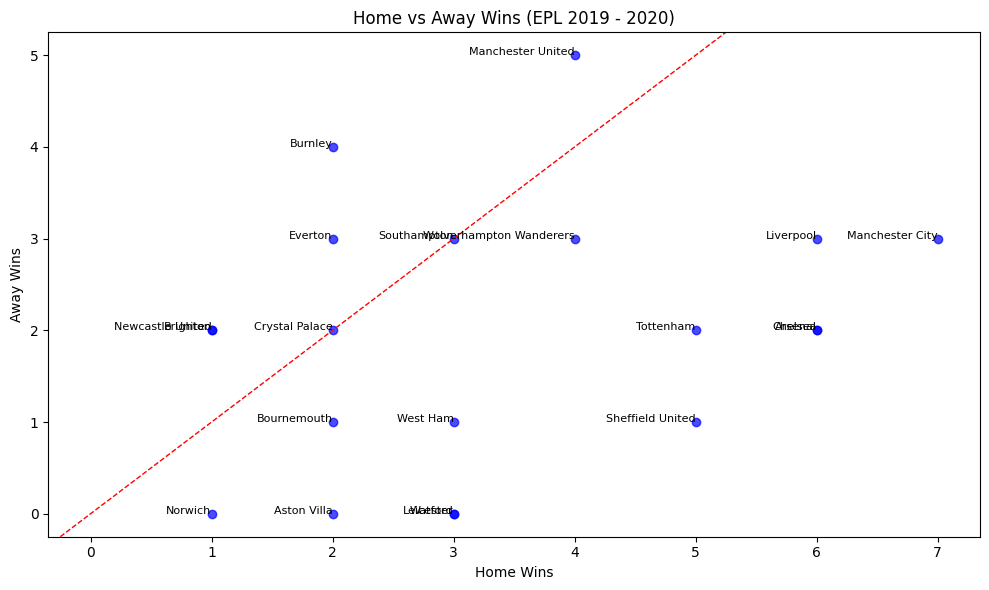

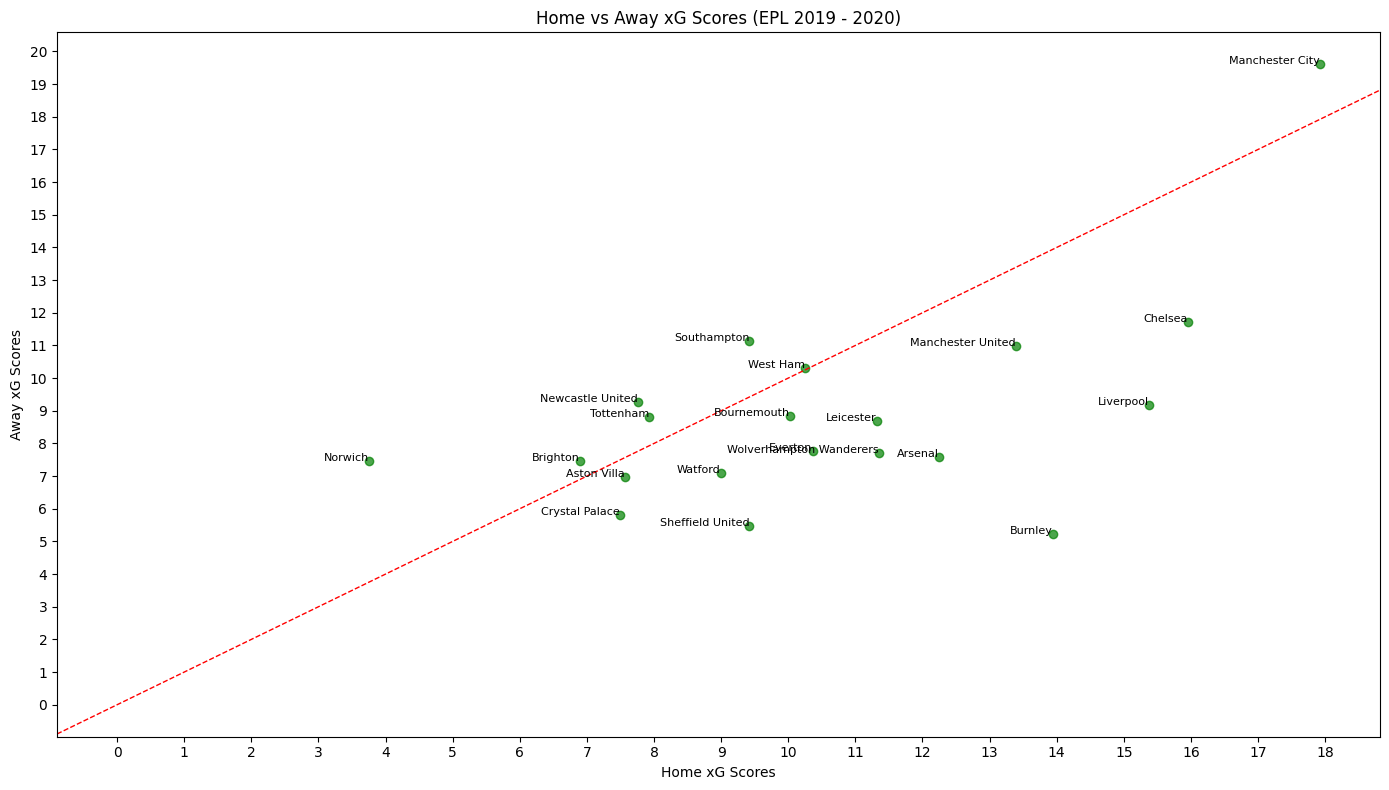

In [ ]:
from src.utility import plot_home_vs_away_xg, load_or_fetch_data, get_teams, plot_home_vs_away_wins
from scipy.stats import ttest_ind, normaltest, levene, mannwhitneyu
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt

# Function to process league data with a date filter
def analyze_league_xg(league, data_file, season, start_date, end_date, exclude_team=None):
    print(f"Processing data for {league} ({season}) with date range {start_date} to {end_date}...")
    
    # Load or fetch data
    data = load_or_fetch_data(data_file, league, season)

    # Extract teams data
    teams = get_teams(data)
    if exclude_team:
        teams = teams[~teams['team'].isin(exclude_team)]
    display(teams)

    # Separate home and away games and filter by date range
    home_games = teams[(teams['h_a'] == 'h') & (teams['date'] >= start_date) & (teams['date'] <= end_date)]
    away_games = teams[(teams['h_a'] == 'a') & (teams['date'] >= start_date) & (teams['date'] <= end_date)]

    # Extract xG values
    home_xG = np.sqrt(home_games['xG'])
    away_xG = np.sqrt(away_games['xG'])

    # Check normality for both groups
    home_normal = normaltest(home_xG).pvalue > 0.05
    away_normal = normaltest(away_xG).pvalue > 0.05

    # Check homogeneity of variances
    equal_variance = levene(home_xG, away_xG).pvalue > 0.05

    # Perform statistical tests
    if home_normal and away_normal and equal_variance:
        ttest_result = ttest_ind(home_xG, away_xG, equal_var=True)
        print(f"T-test for {league} ({season}):\n"
              f"T-statistic = {ttest_result.statistic:.5f}, p-value = {ttest_result.pvalue:.5f}")
        if ttest_result.pvalue < 0.05:
            print("Result: Significant difference in xG between home and away games.")
        else:
            print("Result: No significant difference in xG between home and away games.")
    else:
        mannwhitney_result = mannwhitneyu(home_xG, away_xG, alternative='two-sided')
        print(f"Mann-Whitney U test for {league} ({season}):\n"
              f"p-value = {mannwhitney_result.pvalue:.5f}")
        if mannwhitney_result.pvalue < 0.05:
            print("Result: Significant difference in xG distributions between home and away games.")
        else:
            print("Result: No significant difference in xG distributions between home and away games.")

    # Visualize distributions
    plt.figure(figsize=(10, 5))
    plt.hist(home_xG, bins=15, alpha=0.7, label='Home xG')
    plt.hist(away_xG, bins=15, alpha=0.7, label='Away xG')
    
    period = str(season) + ' - ' + str(int(season) + 1)
    plt.title(f"{league} xG Distribution ({period})")
    plt.xlabel("xG")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Aggregate home and away data
    home_aggregated_data = home_games.groupby('team').agg(
        xG_sum=('xG', 'sum'),
        xGA_sum=('xGA', 'sum'),
        scored_sum=('scored', 'sum'),
        wins_sum=('wins', 'sum'),
        draws_sum=('draws', 'sum'),
        loses_sum=('loses', 'sum')
    ).reset_index()

    away_aggregated_data = away_games.groupby('team').agg(
        xG_sum=('xG', 'sum'),
        xGA_sum=('xGA', 'sum'),
        scored_sum=('scored', 'sum'),
        wins_sum=('wins', 'sum'),
        draws_sum=('draws', 'sum'),
        loses_sum=('loses', 'sum')
    ).reset_index()

    # Generate plots
    plot_home_vs_away_wins(home_aggregated_data, away_aggregated_data, league=league, period=f"{season} - {int(season) + 1}")
    plot_home_vs_away_xg(home_aggregated_data, away_aggregated_data, league=league, period=f"{season} - {int(season) + 1}")

# Analyze data for the period where games were played without audience.
analyze_league_xg(
    league='EPL', 
    data_file='epl_team_data_2020_2021.json', 
    season='2020', 
    start_date='2020-02-01', 
    end_date='2021-07-01',
    exclude_team=[]
)

analyze_league_xg(
    league='EPL', 
    data_file='epl_teams_data_2019_2020.json', 
    season='2019', 
    start_date='2020-02-01', 
    end_date='2021-07-01',
    exclude_team=[]
)